In [1]:
import sys
import os

# Include parent dir
SCRIPT_DIR = os.path.dirname(os.path.abspath('play.ipynb'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

### GRADIENT CONFORMER COMPUTATION

In [52]:
from models.eeg_conformer import Conformer, ConformerConfig

In [53]:
mdl = Conformer(ConformerConfig)

Number of parameters: 0.41M


In [54]:
mdl.apply(mdl.init_weights)

c:\Users\jaulab\Desktop\deepAAD_project\models\eeg_conformer.py:271: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(module.weight, mode= 'fan_out', nonlinearity='relu')


Conformer(
  (embed): PatchEmbedding(
    (shallownet): ModuleList(
      (0): Conv2d(1, 40, kernel_size=(1, 8), stride=(1, 1))
      (1): Conv2d(40, 40, kernel_size=(64, 1), stride=(1, 1))
      (2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ELU(alpha=1.0)
      (4): AvgPool2d(kernel_size=(1, 20), stride=(1, 4), padding=0)
      (5): Dropout(p=0.4, inplace=False)
    )
    (projection): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (encoder): TransformerEncoder(
    (0): EncoderBlock(
      (ln_1): LayerNorm()
      (attn): TemporalSelfAttention(
        (w_q): Linear(in_features=40, out_features=40, bias=True)
        (w_k): Linear(in_features=40, out_features=40, bias=True)
        (w_v): Linear(in_features=40, out_features=40, bias=True)
        (c_proj): Linear(in_features=40, out_features=40, bias=True)
        (attn_dropout): Dropout(p=0.4, inplace=False)
        (resid_dropout): Dropout(p=0.4, inplace=False)
      )
   

In [55]:
x = torch.randn((64, 64, 128))
target = torch.randn(64)
logits, loss = mdl(x, target)
logits.shape, loss

(torch.Size([64]), tensor(0.0422, grad_fn=<NegBackward0>))

In [56]:
loss.backward()

In [57]:
for name, param in mdl.named_parameters():
    if param is not None:
        print(f'Layer {name}: {param.grad}')

Layer embed.shallownet.0.weight: tensor([[[[-1.1589e-01, -1.5722e-01, -1.4105e-01, -1.7125e-01, -1.8921e-01,
           -1.4967e-01, -2.0296e-01, -2.3040e-01]]],


        [[[-8.7813e-02, -7.5573e-02, -8.4988e-02, -4.3029e-02, -2.5184e-02,
           -1.1964e-02, -5.2214e-02, -4.5621e-02]]],


        [[[ 1.7741e-02,  1.9373e-02,  4.6946e-02,  5.7790e-02,  7.1441e-02,
            1.4077e-01,  9.1989e-02,  1.0884e-01]]],


        [[[ 9.3034e-02,  7.0245e-02, -3.6819e-05,  4.3412e-03,  9.4979e-02,
            1.1864e-01,  6.5652e-02,  1.2992e-01]]],


        [[[-1.6778e-01, -1.4607e-01, -1.6653e-01, -3.4871e-02,  3.6625e-02,
            7.3078e-02,  7.1132e-02,  4.2567e-02]]],


        [[[-4.3703e-02, -1.1809e-01, -3.7278e-02, -1.0814e-01, -3.8427e-02,
           -7.2157e-02, -4.8850e-02, -8.6604e-02]]],


        [[[ 1.5178e-02,  3.9372e-02, -3.1354e-02, -1.9728e-02,  9.2279e-02,
           -3.2841e-03,  3.6951e-02, -5.6273e-02]]],


        [[[-3.9252e-02, -4.3034e-02, -2.0035e-02, 

### TENSORBOARD SAVING HISTOGRAM GRAD

In [58]:
from torch.utils.tensorboard import SummaryWriter

In [59]:
writer = SummaryWriter()

In [60]:
for name, param in mdl.named_parameters():
    if param is not None:
        # SAVING NAME, GRAD, EPOCH
        writer.add_histogram(f'{name}.grad', param.grad, 1)

### WANDB GRADIENT SAVING

In [61]:
import wandb

In [62]:
wandb.init(project='gradient_tracking')

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,0


In [46]:
for name, param in mdl.named_parameters():
    if param.grad is not None and 'bias' not in name:
        # detach that eliminates property of the tensor of requiring grad
        wandb.log({f"{name}_grad": wandb.Histogram(param.cpu().detach().numpy()), "epoch": 0}) 

In [47]:
for name, param in mdl.named_parameters():
    if param.grad is not None and 'bias' not in name:
        print(name)

embed.shallownet.0.weight
embed.shallownet.1.weight
embed.shallownet.2.weight
embed.projection.weight
encoder.0.ln_1.weight
encoder.0.attn.w_q.weight
encoder.0.attn.w_k.weight
encoder.0.attn.w_v.weight
encoder.0.attn.c_proj.weight
encoder.0.ln_2.weight
encoder.0.mlp.c_fc.weight
encoder.0.mlp.c_proj.weight
encoder.1.ln_1.weight
encoder.1.attn.w_q.weight
encoder.1.attn.w_k.weight
encoder.1.attn.w_v.weight
encoder.1.attn.c_proj.weight
encoder.1.ln_2.weight
encoder.1.mlp.c_fc.weight
encoder.1.mlp.c_proj.weight
classif.fc.0.weight
classif.fc.3.weight
classif.fc.6.weight


In [49]:
desired_layers = ['classif.fc.0.weight', 
                  'classif.fc.6.weight', 
                  'embed.shallownet.0.weight',
                  'embed.shallownet.2.weight',
                  'encoder.0.attn.w_q.weight',
                  'encoder.3.attn.w_q.weight',
                  'encoder.0.mlp.c_fc.weight',
                  'encoder.3.mlp.c_fc.weight',
                ]

In [50]:
for name, param in mdl.named_parameters():
    if param.grad is not None and name in desired_layers:
        # detach that eliminates property of the tensor of requiring grad
        wandb.log({f"{name}_grad": wandb.Histogram(param.cpu().detach().numpy()), "epoch": 0}) 

### WANDB WATCH

In [4]:
from utils.datasets import CustomDataset
from utils.functional import get_data_path
from torch.utils.data import DataLoader

In [5]:
data_path = get_data_path('C:/Users/jaulab/Desktop/AAD/Data', 'fulsang', filt=False)
dataset = CustomDataset('fulsang', data_path, 'train', 'S1', 128, 1)

In [6]:
data_loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
mdl.to(device)
optimizer = torch.optim.Adam(mdl.parameters(), lr=1e-06, weight_decay = 1e-04)

NameError: name 'mdl' is not defined

In [88]:
import tqdm

In [91]:
wandb.init(project='gradient_tracking')
wandb.watch(models = mdl, log='all', log_freq=len(data_loader))

max_epoch = 5

for epoch in range(max_epoch):

    tqdm_loader = tqdm.tqdm(data_loader, desc=f'Epoch: {epoch}', leave = False, mininterval=0.5)
    
    epoch_losses = []

    for batch_idx, data in enumerate(tqdm_loader):

        eeg = data['eeg'].to(device, dtype=torch.float)
        stima = data['stima'].to(device, dtype=torch.float)

        preds, loss = mdl(eeg, targets = stima)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss)

    print(f'loss: {torch.mean(loss).item()}')
    wandb.log({'train_loss': -torch.mean(loss).item()})

loss: -0.10746944695711136


loss: -0.03581579402089119


loss: 0.10303233563899994


loss: -0.17529068887233734


loss: 0.03303400054574013


loss: -0.12475737184286118


loss: -0.01291625201702118


KeyboardInterrupt: 

In [4]:
from models.dnn import FCNN, CNN

In [10]:
mdl = FCNN(n_hidden=3)

In [6]:
mdl = CNN()

In [11]:
for layer, param in mdl.named_parameters():
    print(layer)

model.1.weight
model.1.bias
model.4.weight
model.4.bias
model.7.weight
model.7.bias
model.10.weight
model.10.bias


In [9]:
x = torch.randn((64,64,50))
preds, loss = mdl(x)
preds.shape, loss

(torch.Size([64]), None)

### REPRODUCIBILITY DATALOADER

In [16]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [17]:
x = torch.arange(40).view(-1, 1)
x.shape

torch.Size([40, 1])

In [18]:
dataset = TensorDataset(x)
dataloader = DataLoader(dataset, num_workers=2, shuffle=True, batch_size = 10)

In [19]:
torch.manual_seed(2809)
for data in dataloader:
    print(data)

[tensor([[28],
        [ 8],
        [18],
        [14],
        [ 0],
        [22],
        [13],
        [ 5],
        [15],
        [ 3]])]
[tensor([[30],
        [32],
        [39],
        [25],
        [16],
        [34],
        [ 9],
        [ 6],
        [38],
        [29]])]
[tensor([[10],
        [ 7],
        [17],
        [ 2],
        [12],
        [ 1],
        [37],
        [36],
        [31],
        [11]])]
[tensor([[26],
        [19],
        [21],
        [ 4],
        [35],
        [23],
        [27],
        [20],
        [33],
        [24]])]


In [22]:
torch.manual_seed(2809)
for data in dataloader:
    print(data, len(data))

[tensor([[28],
        [ 8],
        [18],
        [14],
        [ 0],
        [22],
        [13],
        [ 5],
        [15],
        [ 3]])] 1
[tensor([[30],
        [32],
        [39],
        [25],
        [16],
        [34],
        [ 9],
        [ 6],
        [38],
        [29]])] 1
[tensor([[10],
        [ 7],
        [17],
        [ 2],
        [12],
        [ 1],
        [37],
        [36],
        [31],
        [11]])] 1
[tensor([[26],
        [19],
        [21],
        [ 4],
        [35],
        [23],
        [27],
        [20],
        [33],
        [24]])] 1


### EEG MNE VISUALIZATION

In [2]:
SCRIPT_DIR

'c:\\Users\\jaulab\\Desktop\\deepAAD_project\\notebooks'

In [3]:
import mne
import numpy as np
from utils.datasets import CustomDataset
from utils.functional import get_data_path
import scipy
import os
import torch
global_path = 'C:/users/jaulab/Desktop'

In [46]:
# Leer datos npy
data_path = get_data_path(os.path.join(global_path, 'AAD', 'Data'), 'fulsang', 'thorton')
dataset = CustomDataset('fulsang', data_path, 'train', 'S1', window=128, hop=8, data_type = 'npy')

In [61]:
# Leer datos mat
data_path = get_data_path(os.path.join(global_path, 'AAD', 'Data'), 'fulsang')
dataset = CustomDataset('fulsang', data_path, 'train', 'S1', window=128, hop=8, data_type = 'mat')

In [12]:
# Leer datos directamente DATA_preproc.mat
from utils.functional import normalize_eeg
preproc_data = scipy.io.loadmat(os.path.join(data_path ,'S1_data_preproc.mat'))
eeg_data = np.transpose(preproc_data['data']['eeg'][0,0][0,0])[:64, :]
stima_data = np.squeeze(preproc_data['data']['wavA'][0,0][0,0])
eeg_data = normalize_eeg(torch.tensor(eeg_data))

In [20]:
eeg_data.shape, stima_data.shape

NameError: name 'stima_data' is not defined

In [62]:
eeg_data = dataset.eeg
eeg_data.shape

torch.Size([64, 153600])

In [63]:
# Nombre canales
subj = 'S1'
eeg_path = os.path.join(global_path, 'AAD', 'Fulsang', 'EEG')
data = scipy.io.loadmat(os.path.join(eeg_path, subj+'.mat'))
channel_names = data['data'][0,0]['dim'][0,0]['chan'][0,0]['eeg'][0,0]
channel_names = [chan[0].item() for chan in channel_names][:64]
channel_names[:5]

['Fp1', 'AF7', 'AF3', 'F1', 'F3']

In [64]:
channel_types = ['eeg'] * eeg_data.shape[0]

In [65]:
fs = 64
# fs = 125
eeg_info = mne.create_info(channel_names, sfreq=fs, ch_types=channel_types)
raw = mne.io.RawArray(eeg_data, eeg_info)
raw.info

Creating RawArray with float64 data, n_channels=64, n_times=153600
    Range : 0 ... 153599 =      0.000 ...  2399.984 secs
Ready.


<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 32.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 64.0 Hz
>

In [66]:
montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 32.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 64.0 Hz
>

Effective window size : 32.000 (s)
Plotting power spectral density (dB=True).


c:\Users\jaulab\SSS_Enviroment\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


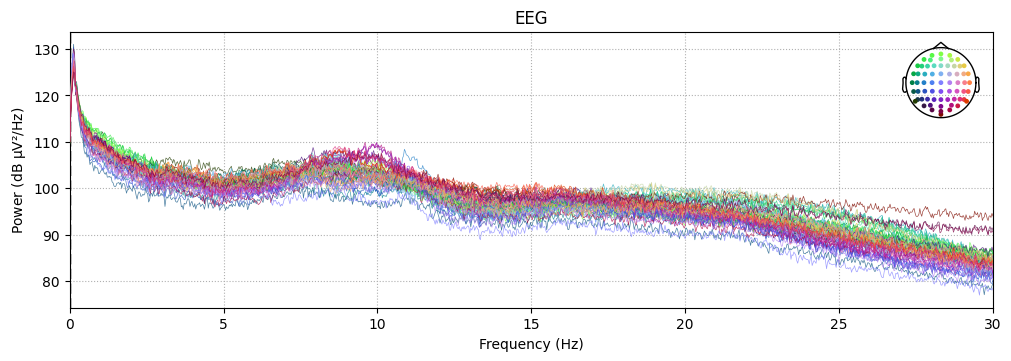

In [67]:
raw.compute_psd(fmax=30).plot(picks="data", exclude="bads", amplitude=False)

In [74]:
x = np.random.randn(60,64,3200)
x.shape

(60, 64, 3200)

In [78]:
for trial in x:
    print(trial.shape)
    break

(64, 3200)


In [73]:
total_duration

2399.984375

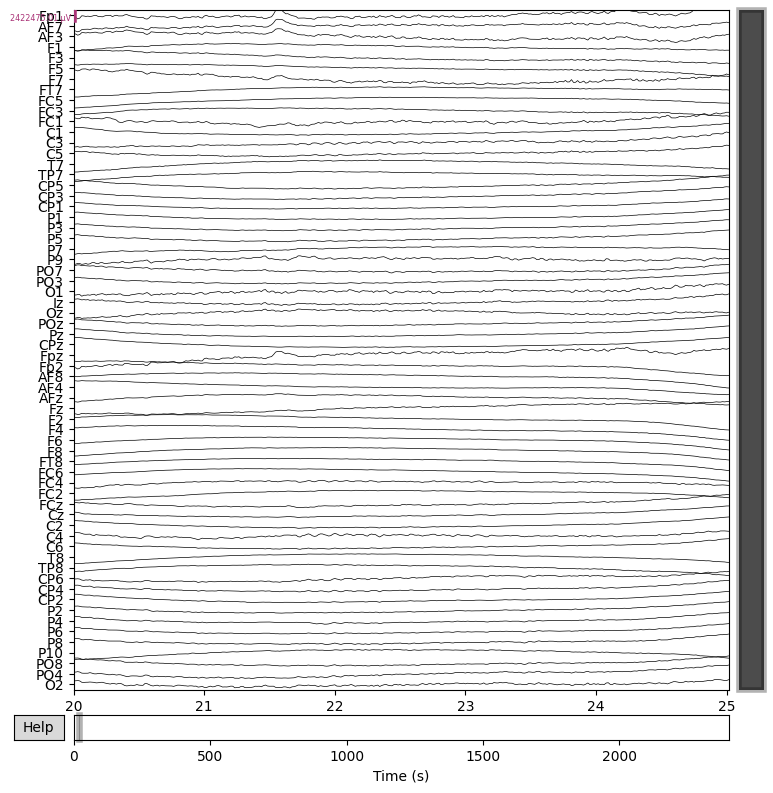

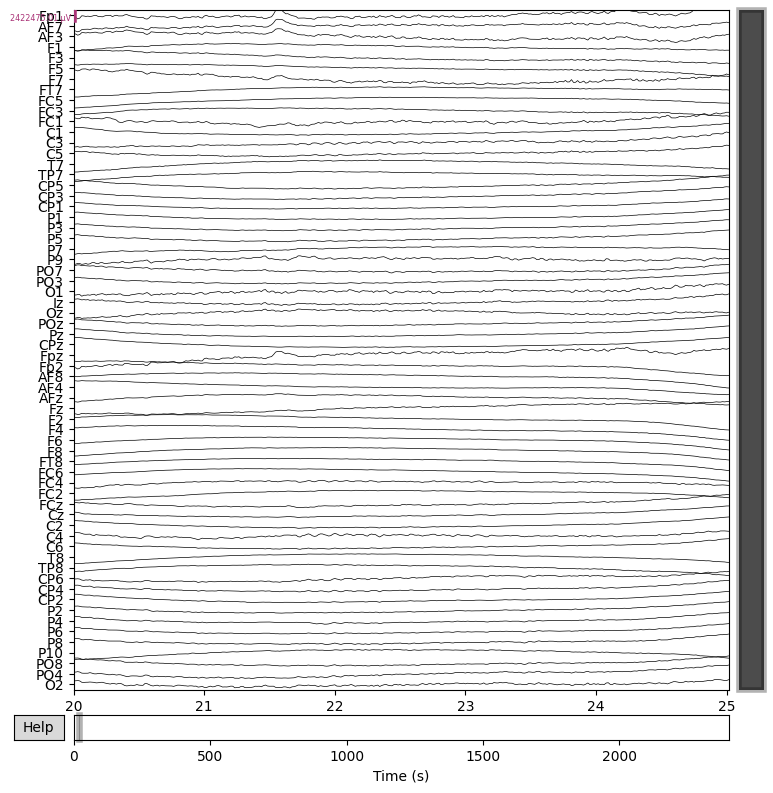

In [72]:
total_duration = raw.times[-1]
start_time = total_duration - 5
raw.plot(start = 20, duration=5, n_channels=64, scalings='auto')

In [38]:
# Aplicar filtrado con la ventana de Hamming
raw.filter(l_freq=0.5, h_freq=8, fir_design='firwin', fir_window='hamming')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<RawArray | 64 x 300000 (2400.0 s), ~146.6 MB, data loaded>

### STIM VISULAIZATION

In [55]:
import matplotlib.pyplot as plt

In [56]:
envelope = dataset.stima
envelope.shape

torch.Size([153600])

In [57]:
envelope = stima_data

NameError: name 'stima_data' is not defined

In [58]:
envelope[:64]  

tensor([ 0.0005, -0.0011,  0.0056,  0.0187,  0.0143,  0.0188,  0.0166,  0.0195,
         0.0382,  0.0409,  0.0400,  0.0435,  0.0399,  0.0427,  0.0396,  0.0403,
         0.0395,  0.0400,  0.0398,  0.0413,  0.0393,  0.0387,  0.0356,  0.0366,
         0.0352,  0.0349,  0.0346,  0.0328,  0.0325,  0.0309,  0.0291,  0.0295,
         0.0288,  0.0287,  0.0278,  0.0284,  0.0272,  0.0265,  0.0270,  0.0274,
         0.0267,  0.0272,  0.0249,  0.0240,  0.0252,  0.0254,  0.0238,  0.0248,
         0.0236,  0.0235,  0.0222,  0.0231,  0.0242,  0.0242,  0.0239,  0.0231,
         0.0237,  0.0228,  0.0227,  0.0251,  0.0274,  0.0293,  0.0305,  0.0455],
       dtype=torch.float64)

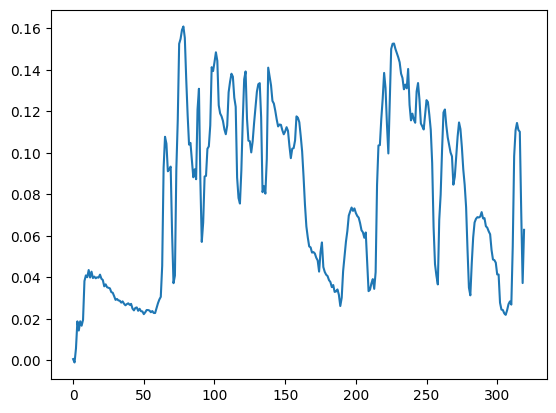

In [60]:
samples = 320 #5s
x = np.arange(samples)
plt.plot(x, envelope[:samples])
plt.show()

### TORCH VIEW

In [83]:
import torch

In [93]:
eeg = torch.randn((48, 64, 3200))
stima = torch.randn((48, 3200))
eeg.shape, stima.shape

(torch.Size([48, 64, 3200]), torch.Size([48, 3200]))

In [95]:
eeg[0,0,:20]

tensor([ 0.9058, -0.7303, -0.7819, -0.0534,  0.9283, -1.1002,  0.0673,  1.3093,
         2.2213, -1.5466,  0.6059, -0.0122, -0.8739,  1.1717, -0.7180,  0.3788,
        -0.0058, -1.3935, -0.3751,  1.2459])

In [96]:
stima[0,:20]

tensor([ 0.3259, -0.8756,  0.2687,  0.3264, -0.0306,  0.1277,  0.2319, -0.9652,
        -1.1888, -0.1164,  1.1225, -1.7293,  0.0452,  0.4111, -0.0043, -0.9332,
        -1.0006,  0.3696,  0.8481, -1.4191])

In [97]:
eeg_cat = eeg.view(eeg.shape[1], eeg.shape[0] * eeg.shape[2])
stima_cat = stima.view(-1)
eeg_cat.shape, stima_cat.shape

(torch.Size([64, 153600]), torch.Size([153600]))

In [98]:
eeg[0, :20]

tensor([ 0.9058, -0.7303, -0.7819, -0.0534,  0.9283, -1.1002,  0.0673,  1.3093,
         2.2213, -1.5466,  0.6059, -0.0122, -0.8739,  1.1717, -0.7180,  0.3788,
        -0.0058, -1.3935, -0.3751,  1.2459])

In [99]:
stima[:20]

tensor([ 0.3259, -0.8756,  0.2687,  0.3264, -0.0306,  0.1277,  0.2319, -0.9652,
        -1.1888, -0.1164,  1.1225, -1.7293,  0.0452,  0.4111, -0.0043, -0.9332,
        -1.0006,  0.3696,  0.8481, -1.4191])

### Bug loading data on dataset.py
En el dataset cuando se carga el eeg o el estímulo en fulsang, el modelo es capaz de entrenar correctamente sólo si se carga tanto eeg como estímulo utilizando la carga tradicional. Si se carga utilizando funciones .view de pytorch, el modelo deja de entrenarse correctamente. ¿A que se debe, es un fallo del tipo de datos o existe una diferencia en la concatención de datos cuando se utiliza hstack respecto de stack y luego view?

In [77]:
# Generate data
n_trials = 48
np.random.seed(1)
eeg_data = [np.random.randn(3200, 64) for n in range(n_trials)]
stima_data = [np.random.randn(3200, 1) for n in range(n_trials)]
eeg_data[0].shape, len(eeg_data), eeg_data[0].dtype, eeg_data[0][:5, 0]

((3200, 64),
 48,
 dtype('float64'),
 array([ 1.62434536,  0.48851815, -1.19926803,  1.90465871,  2.05117344]))

In [91]:
# Stack + view
eeg_data_cat = torch.stack([normalize_eeg(torch.tensor(eeg_data[trial]).T) for trial in range(n_trials)], dim=0)
eeg_data_cat = eeg_data_cat.view(eeg_data_cat.shape[1], eeg_data_cat.shape[0] * eeg_data_cat.shape[2])
eeg_data_cat.shape, eeg_data_cat[0,:5]

(torch.Size([64, 153600]),
 tensor([ 1.6896,  0.5250, -1.2055,  1.9770,  2.1272], dtype=torch.float64))

In [90]:
# Hstack
eeg_data_cat = torch.hstack([normalize_eeg(torch.tensor(eeg_data[trial]).T) for trial in range(n_trials)])
eeg_data_cat.shape, eeg_data_cat[0,:5]

(torch.Size([64, 153600]),
 tensor([ 1.6896,  0.5250, -1.2055,  1.9770,  2.1272], dtype=torch.float64))

In [89]:
# Stack + view
stima_data_cat = torch.squeeze(torch.tensor(np.stack(stima_data)))
stima_data_cat = stima_data_cat.view(-1)
stima_data_cat.shape, stima_data_cat[:5]

(torch.Size([153600]),
 tensor([-2.2720, -1.8724,  0.2086, -0.3089,  0.8754], dtype=torch.float64))

In [88]:
# Vstack
stima_data_cat = torch.squeeze(torch.vstack([torch.tensor(stima_data[trial]) for trial in range(n_trials)]))
stima_data_cat[:5], stima_data_cat.shape

(tensor([-2.2720, -1.8724,  0.2086, -0.3089,  0.8754], dtype=torch.float64),
 torch.Size([153600]))

El fallo en la simulación ocurre con el ajuste de datos de eeg cuando se realiza stack + view en vez de hstack aunque como se ha comprobado no tiene por que existir diferencia entre ambos métodos